# Sign Language MNIST

## Prepare Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

train = pd.read_csv('./sign_mnist_train.csv')
test  = pd.read_csv('./sign_mnist_test.csv')

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [2]:
from tensorflow.keras.utils import to_categorical

def convert_dataset(ds, pixles_x, pixels_y, length, features):
    # conversion by: https://www.kaggle.com/joechen02/sign-language-mnist
    y = np.array(ds['label'])
    ds.drop('label', axis=1, inplace=True)
    x = np.array(ds.values.reshape(ds.shape[0],pixles_x,pixels_y,1))
    x = x.astype('float32') / 255
    y = to_categorical(y, features)
    return (x,y)

x_train, y_train = convert_dataset(train, 28, 28, len(train), 25)
x_test, y_test = convert_dataset(test, 28, 28, len(test), 25)

print(x_train.shape)
print(y_train.shape)
print()
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 25)

(7172, 28, 28, 1)
(7172, 25)


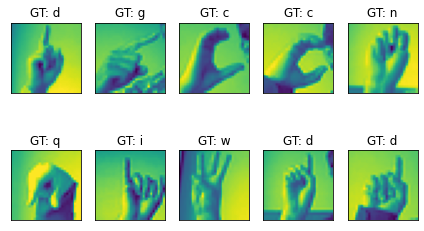

In [3]:
import string

def show_img(x, gt, preds, r_start, r_amount, rows, cols):
    fig, ax = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,)
    ax = ax.flatten()
    letters = [el for el in string.ascii_lowercase]
    for i in range(r_start, r_start + r_amount):
        ax[i-r_start].imshow(x[i])
        title = 'GT: ' + letters[int(np.where(gt[i]==1)[0])] 
        if preds is not None:
            title = title + ', L: ' + letters[int(preds[i])]
        ax[i-r_start].title.set_text(title)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
show_img(x_train, y_train, None, 0, 10, 2, 5)

## Create CNN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, AlphaDropout, BatchNormalization
model = Sequential(name="Underfitted_CNN")

model.add(Conv2D(filters=128,
                 kernel_size=3,
                 kernel_initializer="lecun_normal", bias_initializer="zeros", activation='selu',
                 padding='same',
                 input_shape=x_train[0].shape))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=128,
                 kernel_size=3,
                 kernel_initializer="lecun_normal", bias_initializer="zeros", activation='selu',
                 padding='same'))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 kernel_initializer="lecun_normal", bias_initializer="zeros", activation='selu',
                 padding='same',
                 input_shape=x_train[0].shape))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 kernel_initializer="lecun_normal", bias_initializer="zeros", activation='selu',
                 padding='same'))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, kernel_initializer="lecun_normal", bias_initializer="zeros", activation='selu'))
model.add(AlphaDropout(0.25))
model.add(Dense(128, kernel_initializer="lecun_normal", bias_initializer="zeros", activation='selu'))
model.add(AlphaDropout(0.25))
model.add(Dense(y_train[0].shape[0], activation='softmax'))

model.summary()

Model: "Underfitted_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)      

## Train and save model 

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss',
                           restore_best_weights=True,
                           patience=5,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.2,
                              min_lr=0.0001,
                              patience=3,
                              verbose=1)

epochs = 6

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/6
344/344 [==============================] - 61s 171ms/step - loss: 2.7393 - acc: 0.2177 - val_loss: 0.2246 - val_acc: 0.9201
Epoch 2/6
344/344 [==============================] - 68s 198ms/step - loss: 0.2019 - acc: 0.9338 - val_loss: 0.0081 - val_acc: 0.9971
Epoch 3/6
344/344 [==============================] - 64s 186ms/step - loss: 0.0433 - acc: 0.9865 - val_loss: 0.0046 - val_acc: 0.9987
Epoch 4/6
344/344 [==============================] - 59s 172ms/step - loss: 0.0171 - acc: 0.9942 - val_loss: 0.0025 - val_acc: 0.9995
Epoch 5/6
344/344 [==============================] - 63s 184ms/step - loss: 0.0349 - acc: 0.9891 - val_loss: 9.6751e-06 - val_acc: 1.0000
Epoch 6/6
344/344 [==============================] - 68s 197ms/step - loss: 0.0199 - acc: 0.9941 - val_loss: 0.0025 - val_acc: 0.9993


In [7]:
model.save(model.name + '.h5')

## Evaluate model


++++++++++++ Test data ++++++++++++
loss=0.3596 acc=0.9525


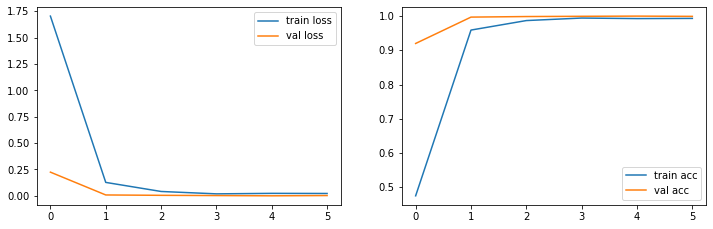

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\n++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}")

In [9]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

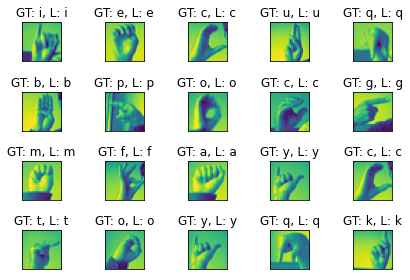

In [10]:
show_img(x_test, y_test, prediction_classes, 100, 20, 4, 5)

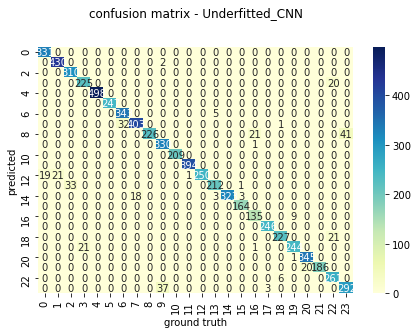

In [11]:
from sklearn import metrics

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.title('confusion matrix - ' + model.name, y=1.1)
plt.ylabel('predicted')
plt.xlabel('ground truth')
plt.show()